# Trabajo Práctico N°3 - CNN
## Germán Bertachini - Legajo 58750

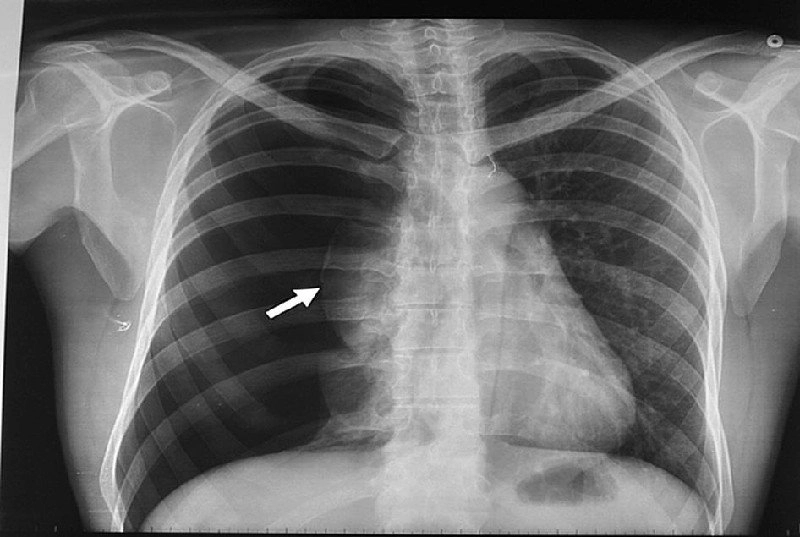

Para este trabajo se entrenará un modelo de segmentación basado en la arquitectura U-Net para resolver el problema de segmentación de neumotórax. Se utilizará la métrica Dice, también llamada coeficiente Sorensen-Dice, que se presenta a continuación.

El coeficiente de Dice es un estadístico utilizado para comparar la similitud de dos muestras. La fórmula original de Sørensen estaba destinada a ser aplicada a datos de presencia/ausencia, y se define de la siguiente forma:


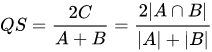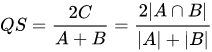


donde A y B son el número de especies en las muestras A y B, respectivamente, y C es el número de especies compartidas por las dos muestras; QS es el cociente de similitud y varía de 0 a 1. Esta expresión se extiende fácilmente a la abundancia en lugar de la presencia / ausencia de especies. De esta manera, podemos usarlo como función de costo e identificar de manera clara cuan bien está funcionando nuestro modelo.


**Librerías a utilizar**

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [1]:
from PIL import Image
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Dropout, Concatenate, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [4]:
path = "./siim-acr-pneumothorax/"

### Funciones Auxiliares

In [5]:
def dice_coef(y_true, y_pred, smooth=0):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [6]:
def conv_block(m, dim, acti, bn, res, do=0):
    n = Conv2D(dim, 3, activation=acti, padding='same')(m)
    n = BatchNormalization()(n) if bn else n
    n = Dropout(do)(n) if do else n
    n = Conv2D(dim, 3, activation=acti, padding='same')(n)
    n = BatchNormalization()(n) if bn else n
    return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
    if depth > 0:
        n = conv_block(m, dim, acti, bn, res)
        m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
        m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
        if up:
            m = UpSampling2D()(m)
            m = Conv2D(dim, 2, activation=acti, padding='same')(m)
        else:
            m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
        n = Concatenate()([n, m])
        m = conv_block(n, dim, acti, bn, res)
    else:
        m = conv_block(m, dim, acti, bn, res, do)
    return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
         dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
    i = Input(shape=img_shape)
    o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
    o = Conv2D(out_ch, 1, activation='sigmoid')(o)
    return Model(inputs=i, outputs=o)

In [29]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, path, img_prefix, mask_prefix, transform=False, batch_size=4, dim=(256,256), 
                 n_channels=1, shuffle=True,only_positives=False,mode='train',size=1000):
        'Initialization'
        self.path = path
        self.only_positives=only_positives
        self.transform = transform
        self.n_channels = n_channels
        self.img_prefix = img_prefix
        self.mask_prefix = mask_prefix
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.filenames=[]
        
        #self.filenames= [file.name for file in Path(path).glob("png_images/*.png")]
        
        all_filenames= [file.name for file in Path(path).glob("png_images/*.png")]
        
        for i, filename in enumerate(all_filenames):
            if len(self.filenames)==size:
                break
            kind=filename.split('_')[2]
            if kind=='0' and only_positives==True:
                continue
            elif filename.split('_')[1]!=mode and mode!='both':
                continue
            else:
                self.filenames.append(filename)
                
                
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(filenames)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        np.random.shuffle(self.filenames)

    def __data_generation(self, filenames):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, filename in enumerate(filenames):
            img = Image.open(self.path + self.img_prefix + filename).resize(self.dim)
            mask = Image.open(self.path + self.mask_prefix + filename).resize(self.dim)
            img = np.array(img).reshape(*self.dim, self.n_channels)/255
            mask = np.array(mask).reshape(*self.dim, self.n_channels)/255
            
#            if filename.split('_')[2]=='0':
#                self.filenames.pop(i)
#                continue

            if self.transform:
                trf = self.transform(image = img, mask = mask)
                X[i,...] = trf['image']
                y[i,...] = trf['mask']
            else:
                X[i,...] = img
                y[i,...] = mask
                
        return X,y

### Data Augmentation

Se utilizan 5 casos par ver el efecto que tiene realizar data augmentation en nuestro data set.

**Caso 1** - Flip

In [8]:
transform_flip = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5)
])

**Caso 2** - Shift

In [9]:
transform_shift = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, p=.75),
])

**Caso 3** - Elastic Transform

In [10]:
transform_elastic = A.Compose([
    A.ElasticTransform(),
])

**Caso 4** - Cambio en el brillo y contraste

In [11]:
transform_brightness = A.Compose([
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2,p=0.5),
])

**Caso 5** - Todas las transformaciones

In [12]:
transform_all = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, p=.75),
    A.ElasticTransform(),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2,p=0.5),
])

## Data Generator

### División del Dataset

Se generan diversos datasets según la presencia de la patología, batch size, tipo de muestra (train o test) y tamaño de la muestra. A continuación, se presentan alguno de los DS utilizados.

**Dataset 1** - Sólo imágenes con patologías, batch_size = 12, size=500

In [38]:
datagen_onlytrue = DataGenerator(
    path,
    "png_images/",
    "png_masks/",
    #transform = transform,
    only_positives=True,
    batch_size = 12,
    size=500

)

**Dataset 2** - Batch_size = 12, size=500

In [36]:
#Todas las imagenes
datagen = DataGenerator(
    path,
    "png_images/",
    "png_masks/",
    transform = transform_all,
    batch_size = 12,
    size=500
)

**Dataset 3** - Imágenes de entrenamiento.  Mode='train', batch_size = 64

In [32]:
datagen_train = DataGenerator(
    path,
    "png_images/",
    "png_masks/",
    mode='train',
    batch_size = 64,
    size=500
)

**Dataset 4** - Imágenes de testeo.  Mode='test', batch_size = 64

In [33]:
datagen_test = DataGenerator(
    path,
    "png_images/",
    "png_masks/",
    mode='test',
    batch_size = 64
)

**Dataset 5** - Dataset de validación

In [34]:
datagen_val = DataGenerator(
    path,
    "png_images/",
    "png_masks/",
    transform = False,
    batch_size = 4,
    size=64
)

### Modelo

Se utiliza el siguiente modelo de UNet para nuestra red neuronal,

**Modelo 1**

In [39]:
model = UNet((256,256,1),start_ch=32,depth=3,batchnorm=False, residual = True)

**Modelo 2**

In [39]:
model = UNet((256,256,1),start_ch=32,depth=3,batchnorm=True, residual = True)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [40]:
model.compile(loss=dice_coef_loss, optimizer=Adam(1e-3))

In [ ]:
model.save_weights('./checkpoints/id1')

In [ ]:
model.load_weights('./checkpoints/id1')

In [ ]:
preds = model.predict(datagen_onlytrue)

Epoch 1/10
 1/31 [..............................] - ETA: 1:29:09 - loss: 0.9902

In [1]:
preds = model.predict(datagen)

NameError: name 'model' is not defined

In [ ]:
for idx in range(16):
    plt.imshow(datagen_onlytrue[0][1][idx].reshape(256,256))
    plt.show()
    plt.imshow(preds[idx,...].reshape(256,256))
    plt.show()

### Resultados

A continuación se presentan los resultados del trabajo sobre este problema con el dataset otorgado por la cátedra. Se trabaja y manipula el dataset mediante diferentes métodos de *data augmentation*. En promedio se dejó correr a cada modelo unos 140 epochs o hasta que no se vieran cambios significativos.


| **ID** | **Score** | **Dataset** | **Data Augmentation** | **Batch Size** | **Size** | **Sólo positivos** | **Modelo** |
|:------:|:---------:|:-----------:|:---------------------:|:--------------:|:--------:|:------------------:|:----------:|
|    1   |   0.0586  |      1      |          N/A          |       12       |    500   |       *True*       |      1     |
|    2   |   0.0994  |      1      |         Caso 1        |       12       |    500   |       *True*       |      1     |
|    3   |   0.1203  |      1      |         Caso 2        |       12       |    500   |       *True*       |      1     |
|    4   |   0.1254  |      1      |         Caso 3        |       12       |    500   |       *True*       |      1     |
|    5   |   0.1166  |      1      |         Caso 4        |       12       |    500   |       *True*       |      1     |
|    6   |   0.0825  |      1      |         Caso 5        |       12       |    500   |       *True*       |      1     |
|    7   |   0.0961  |      2      |         Caso 2        |       48       |   1000   |       *False*      |      2     |
|    8   |   0.1020  |      2      |         Caso 3        |       48       |   1000   |       *False*      |      2     |
|    9   |   0.1189  |      2      |         Caso 4        |       48       |   1000   |       *True*       |      2     |
|   10   |   0.1355  |      2      |         Caso 5        |       24       |   1000   |       *False*      |      1     |

El mejor resultado obtenido se dio para el modelo *ID°6* con data augmentation en muchos factores obteniendose un score de *0.0825*. Se puede apreciar que para el caso del dataset presentado el uso de data augmentation no presenta una mejora significativa en los resultados. Se estima que esto se debe a la naturaleza de las radiografías utilizadas que carecen de grandes detalles o figuras/patrones de cierta complejidad. En concordancia con la anterior, el segundo mejor score fue usando el modelo *ID°1* sin data augmentation, consideramos que en parte esto se debe a que fue el primer modelo analizado por lo cual hay un bias en cuanto a la cantidad de epochs y depuraciones que se hicieron sobre el mismo.


Para todos los modelos se utilizó un optmizador Adam de parámetro $\alpha=1e^{-4}$.

A continuación, se presentan algunas de las mejores prediciones obtenidas.

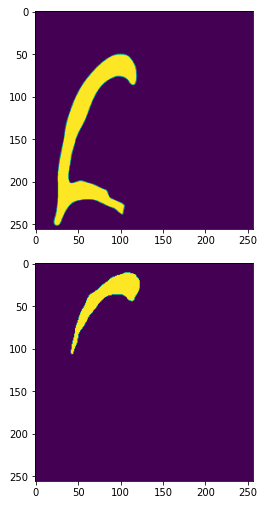
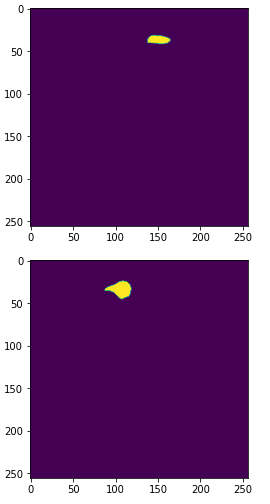
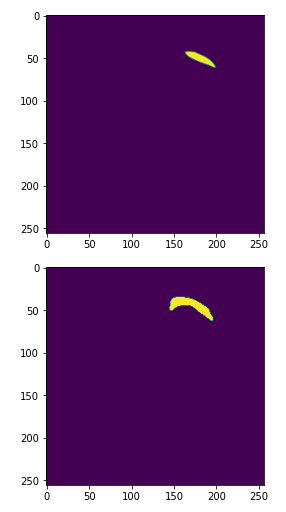
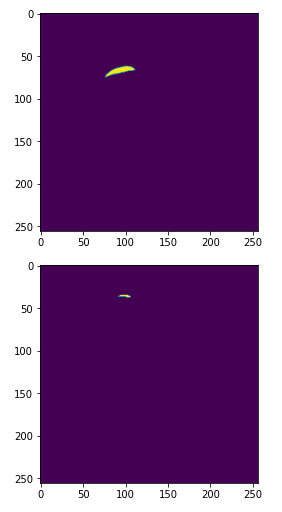
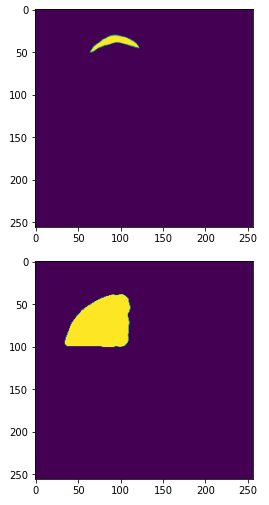

### Conclusiones

Se considera que se logró llegar al objetivo planteado por la cátedra, pudiendo obtener segmentaciones de pulmotorax con cierto nivel de precisión. Lamentablemente, se observa que al nivel de segmentación llegado no coincide con los valores obtenidos como score. Por otro lado, los filtros de *data augmentation* aplicados sobre el dataset no aportan una mejora significativa, esto se puede atribuir al tipo de dataset estudiado.

El desarrollo del trabajo práctico tuvo grandes dificultades a nivel entrenamiento de la red neuronal, estas limitaciones sin duda impactaron en los valores obtenidos. Al realizar dicho entrenamiento sobre Google Colab, y por la complejidad inherente del mismo, era indispensable tener disponible una GPU, recurso que sólo estaba disponible en rangos acotados del día. De igual manera el entrenamiento fue lento, requiriendo entrenar cada modelo alrededor de una hora, teniendo problemas de pérdidas de modelos en el medio debido al timeout del sistema e imposibilidad de realizar predicciones. Se considera que con mayores recursos técnicos se podrían obtener predicciones aún mejores.

### Anexo

**Captura caso ID 1** 

Optimizador: Adam(1e-4)

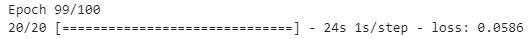

**Captura caso ID 2**

Optimizador: Adam(1e-4)

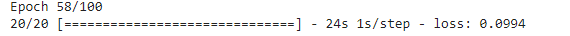

**Captura caso ID 3**

Optimizador: Adam(1e-4)

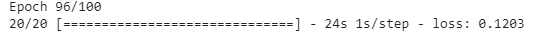

**Captura caso ID 4**

Optimizador: Adam(1e-4)

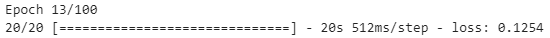

**Captura caso ID 5**

Optimizador: Adam(1e-4)

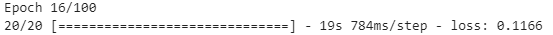

**Captura caso ID 6**

Optimizador: Adam(1e-4)

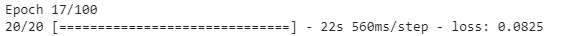

**Captura caso ID 7**

Optimizador: Adam(1e-4)

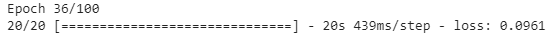

**Captura caso ID 8**

Optimizador: Adam(1e-4)

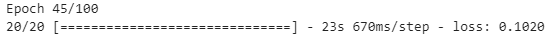

**Captura caso ID 9**

Optimizador: Adam(1e-4)

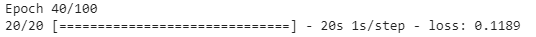

**Captura caso ID 10**

Optimizador: Adam(1e-4)

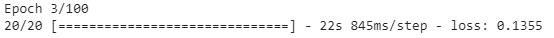